In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#
# Much appreciation to the Pymoo project for providing the optimization framework used herein:
#
# pymoo: Multi-objective Optimization in Python
# https://github.com/anyoptimization/pymoo
# https://pymoo.org/index.html
#



# The Open Sleeve Dipole (Part 2)

The results from the previous notebook seem unrealistically (?) positive (maximum VSWR of 1.19 from 3.5 - 4.0 MHz).

Exploring further....

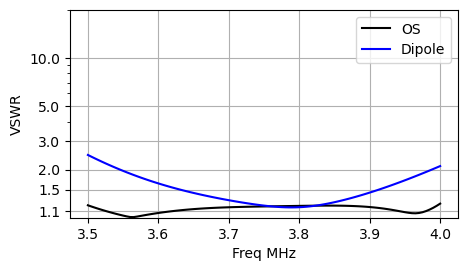

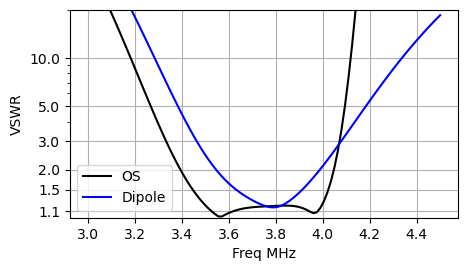

In [9]:

#
# Hand-coded sanity check - verify results of previous notebook
#

# Results from prev notebook (half-element lengths)
ACTIVE_EL_LEN = 20.44303938
PASSIVE_EL_LEN = ACTIVE_EL_LEN * 0.88388413
EL_SPACING = 0.95303555
A_DEG = 180                         # 39.972m @ 3.75 MHz (VF not considered)
B_DEG = 91                          # 20.208m
DIPOLE_LEN = 19.445151878961305


necstr_tl = """CE Template
{gw_cards}
GW 20 1 0 0 2 0 0.001 2 0.001
GW 30 1 0 0 1 0 0.001 1 0.001
GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
TL 1 -1 20 -1 50 {tla} 0 0 0 0
TL 20 -1 30 -1 75 {tlb} 0 0 0 0
EX 4 30 1 1 1.0 0.0
FR 0 {fnum} 0 0 {flow} {fstep}
XQ 0
EN
"""
gw_os = """GW 1 10 0 0 {az} 0 {alen} {az} 0.000814
GW 1 10 0 0 {pz} 0 {plen} {pz} 0.000814"""
gw_dipole = """GW 1 10 0 0 {z} 0 {len} {z} 0.000814"""

def d2m(d):                                 # Degrees to meters @ 3.75 MHz
    return 299.792458 / 3.75 * d / 360.0 

from necutil import nec5_sim_stdio3,plot_vswr
res = nec5_sim_stdio3([
    necstr_tl.format(gw_cards=gw_os.format(az=24.4,alen=ACTIVE_EL_LEN,pz=24.4+EL_SPACING,plen=PASSIVE_EL_LEN), fnum=101, flow=3.5, fstep=0.005, tla=d2m(180),tlb=d2m(91)),
    necstr_tl.format(gw_cards=gw_dipole.format(z=24.4,len=DIPOLE_LEN), fnum=101, flow=3.5, fstep=0.005, tla=d2m(180),tlb=d2m(91)),
    necstr_tl.format(gw_cards=gw_os.format(az=24.4,alen=ACTIVE_EL_LEN,pz=24.4+EL_SPACING,plen=PASSIVE_EL_LEN), fnum=101, flow=3.0, fstep=0.015, tla=d2m(180),tlb=d2m(91)),
    necstr_tl.format(gw_cards=gw_dipole.format(z=24.4,len=DIPOLE_LEN), fnum=101, flow=3.0, fstep=0.015, tla=d2m(180),tlb=d2m(91))])
plot_vswr([res[0][0][0],res[1][0][0]], tags=['OS','Dipole'])
plot_vswr([res[2][0][0],res[3][0][0]], tags=['OS','Dipole'])



The VSWR goes off the rails rapidly over 4.0 MHz.<br>
Let's try running the previous notebook's optimization with some wider frequency ranges:

In [ ]:
# 3.5-4.1 MHz
#     Optimum parameters (active el len, parasitic as fraction of active el, spacing:
#     [20.28556498  0.87615545  0.56846079]
#     Objective = max VSWR within band:  1.3044936656951904
#     Matching sections (degrees): [z0a, z0b] [179.  91.]

# 3.5-4.2 MHz
#     Optimum parameters (active el len, parasitic as fraction of active el, spacing:
#     [20.167111    0.86669868  0.3609081 ]
#     Objective = max VSWR within band:  1.4418385028839111
#     Matching sections (degrees): [z0a, z0b] [179.  89.]

# 3.5-4.3 MHz
#     Optimum parameters (active el len, parasitic as fraction of active el, spacing:
#     [20.05606259  0.85641845  0.30168167]
#     Objective = max VSWR within band:  1.6152937412261963
#     Matching sections (degrees): [z0a, z0b] [178.  91.]

# 3.4-4.1 MHz
#     Optimum parameters (active el len, parasitic as fraction of active el, spacing:
#     [20.69629166  0.86592225  0.37965867]
#     Objective = max VSWR within band:  1.4929640293121338
#     Matching sections (degrees): [z0a, z0b] [179.  89.]

# 3.3-4.2 MHz
#     Optimum parameters (active el len, parasitic as fraction of active el, spacing:
#     [21.05731761  0.83859896  0.3081136 ]
#     Objective = max VSWR within band:  2.0157692432403564
#     Matching sections (degrees): [z0a, z0b] [179.  87.]


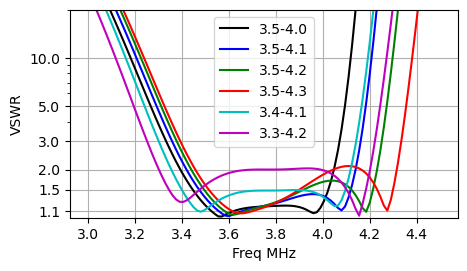

In [15]:
params = [
    [20.44303938,20.44303938*0.88388413,0.95303555,180,91,'3.5-4.0'],
    [20.28556498,20.28556498*0.87615545,0.56846079,179,91,'3.5-4.1'],
    [20.167111,20.167111*0.86669868,0.3609081,179,89,'3.5-4.2'],
    [20.05606259,20.05606259*0.85641845,0.30168167,178,91,'3.5-4.3'],
    [20.69629166,20.69629166*0.86592225,0.37965867,179,89,'3.4-4.1'],
    [21.05731761,21.05731761*0.83859896,0.3081136,179,87,'3.3-4.2']
]

designs = []
tags = []
for i in range(len(params)):
    designs.append(necstr_tl.format(gw_cards=gw_os.format(az=24.4,alen=params[i][0],pz=24.4+params[i][2],plen=params[i][1]), fnum=101, flow=3.0, fstep=0.015, tla=d2m(params[i][3]),tlb=d2m(params[i][4])))
res = nec5_sim_stdio3(designs)

zs = [r[0][0] for r in res]
tags = [p[5] for p in params]

plot_vswr(zs, tags=tags, colors=['k','b','g','r','c','m'])




Trading off some in-band SWR for additional bandwidth looks promising.